# S3D (Separable 3D) - Design Alternative 3

`Warning:` Do not run all the code, read the notes first before running them as they may reduce your device's memory when not careful, leading to a kernel crash or Out-Of-Memory (OOM) Error

**Local System Specifications used to train the model:** <br>
| Component  | Device   |
| :------------- | :--------------- | 
| CPU   | AMD Ryzen 5 5600x     | 
| GPU   | Nvidia GeForce RTX 3070  8GB   | 
| RAM   | 32 GB     | 


## Create the dataset

#### Import Libraries and Configure Device

In [1]:
## Uncomment if you are running on colab

#!pip install keras-tuner imageio opencv-python tqdm seaborn scikit-learn
#!pip install -q git+https://github.com/tensorflow/docs

#!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF101/UCF101.rar
#!unrar x UCF101.rar

In [2]:
from tqdm import tqdm
import random
import pathlib
import itertools
import collections 
import os

import imageio
import shutil
import cv2
import einops
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow_docs.vis import embed
import tensorflow as tf
import keras
import keras_tuner as kt
from keras import layers

2024-11-29 23:12:08.434605: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732893128.443762   41618 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732893128.446354   41618 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 23:12:08.464561: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
## Limit usage of VRAM to prevent OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_virtual_device_configuration(gpu,
                                                             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5820)])
    
tf.config.run_functions_eagerly(True)

`Note`: Ikaw bahala sa pag lagay ng memory limit, check your gpu specs and refer to that specs when changing.

#### Visualize the data first

In [4]:
def visulize_data(fil_dir):
    """ 
    Let's you visualize the video

    Args:
        fil_dir: Directory of files

    Returns:
        Plot of videos along with the labels

    """

    plt.figure(figsize=(20, 20))
    all_class_names = os.listdir(path=fil_dir)
    random_range = random.sample(range(len(all_class_names)),
                                  len(all_class_names)-random.randrange(1, len(all_class_names)))

    for counter, rand_idx in enumerate(random_range, 1):
        selected_class_name = all_class_names[rand_idx]
        video_files_names_list = os.listdir(f'{fil_dir}/{selected_class_name}')
        selected_video_file_name = random.choice(video_files_names_list)

        video_reader = cv2.VideoCapture(f'{fil_dir}/{selected_class_name}/{selected_video_file_name}')
        _, frame = video_reader.read()
        video_reader.release()

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        cv2.putText(rgb_frame, selected_class_name, (10,30), cv2.FONT_HERSHEY_DUPLEX, 1, (0,0,255), 2)

        plt.subplot(5, 4, counter)
        plt.imshow(rgb_frame)
        plt.axis('off')

#### Loading of dataset

In [5]:
## Define the dimensions of frames in the set of frames created (Default params muna)
HEIGHT = 224
WIDTH = 224
SEQUENCE_LENGTH = 20 # small frame raw para small memory at computation ang gawin, ndi kakakayanin ng mga nasa 16GB lang
LABELS = sorted(['BarbellCurl', 'Deadlift', 'Squat', 'LateralRaises', 'OverheadPress'
          ]) # Eto muna

- `Note`: This can be changed later on once model is okay

In [6]:
def split_dataset(dataset_dir, 
                  splits={"train": 0.7, "val": 0.15, "test": 0.15}, 
                  seed=42, 
                  selected_classes=None):
    """
    Split the video dataset into train, validation, and test sets and save to subdirectories.
    Ensures no data duplication across splits.
    """
    random.seed(seed)
    
    # Convert dataset directory to Path object
    dataset_dir = pathlib.Path(dataset_dir)
    splits_dirs = ["train", "val", "test"]

    # Remove existing split directories to avoid data overlap
    for split in splits_dirs:
        split_dir = dataset_dir / split
        if split_dir.exists():
            shutil.rmtree(split_dir)

    # Iterate over each class folder in the dataset
    class_dirs = [f for f in dataset_dir.iterdir() if f.is_dir()]
    
    # Filter classes if `selected_classes` is provided
    if selected_classes:
        class_dirs = [f for f in class_dirs if f.name in selected_classes]
    
    for class_dir in tqdm(class_dirs, desc="Processing classes", unit="class"):
        print(f"\nProcessing class: {class_dir.name}")
        
        # Get a list of video files in the class directory
        video_files = [f for f in class_dir.iterdir() if f.is_file()]
        
        # Shuffle the video files for randomness
        random.shuffle(video_files)
        
        # Calculate the split indices based on the provided proportions
        num_videos = len(video_files)
        train_end = int(splits["train"] * num_videos)
        val_end = train_end + int(splits["val"] * num_videos)
        
        # Split the video files into train, val, and test sets
        train_files = video_files[:train_end]
        val_files = video_files[train_end:val_end]
        test_files = video_files[val_end:]
        
        # Move files to respective split directories
        for split, files in zip(splits_dirs, [train_files, val_files, test_files]):
            split_dir = dataset_dir / split / class_dir.name
            split_dir.mkdir(parents=True, exist_ok=True)  # Create the class folder in the split directory
            
            for file in tqdm(files, desc=f"Moving files to {split}/{class_dir.name}", unit="file"):
                shutil.move(str(file), str(split_dir / file.name))
    
    print("\nDataset split complete!")

In [7]:
## File path
file_path = './Workout/' 

`Caution`: Do not run the code below if you ran it the first time, mawawala mga directories, tsaka ko na muna aayusin

In [8]:
## Split the dataset, automatically returns 0 if already run once
#split_dataset(file_path, splits={"train": 0.7, "val": 0.15, "test": 0.15}, selected_classes=LABELS)

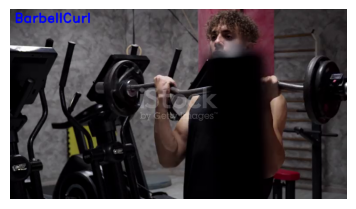

In [9]:
visulize_data(file_path + 'train')

In [10]:
## Creates a path to the dataset
dataset_paths = {'train':pathlib.Path(f'{file_path}train'),
                    'val':pathlib.Path(f'{file_path}val'),
                    'test':pathlib.Path(f'{file_path}test')}


#### Create Frames from each video and Augment

In [11]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

In [12]:
def frames_from_video_file(video_path, n_frames, output_size=(224, 224)):
    result = []
    src = cv2.VideoCapture(str(video_path))
    video_length = int(src.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_step = max(1, video_length // n_frames)

    if video_length <= n_frames:
        start = 0
    else:
        max_start = video_length - n_frames * frame_step
        start = random.randint(0, max_start)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    ret, frame = src.read()
    if ret:
        result.append(format_frames(frame, output_size))

    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            result.append(format_frames(frame, output_size))
        else:
            result.append(np.zeros_like(result[0]))

    src.release()
    result = np.array(result)[..., [2, 1, 0]]
    return result

In [13]:
def augment_frames(frames):
    augmented_frames = []
    for frame in frames:
        frame = tf.image.random_flip_left_right(frame)
        frame = tf.image.random_brightness(frame, max_delta=0.2)
        frame = tf.image.random_contrast(frame, lower=0.8, upper=1.2)
        frame = tf.image.random_saturation(frame, lower=0.8, upper=1.2)
        augmented_frames.append(frame)
    return tf.stack(augmented_frames)

In [14]:
class FrameGenerator:
    def __init__(self, path, n_frames, training=False, augment=False):
        self.path = path
        self.n_frames = n_frames
        self.training = training
        self.augment = augment
        self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
        self.class_ids_for_name = {name: idx for idx, name in enumerate(self.class_names)}

    def get_files_and_class_names(self):
        video_paths = list(self.path.glob('*/*.avi')) + list(self.path.glob('*/*.mov')) + list(self.path.glob('*/*.mp4'))
        classes = [p.parent.name for p in video_paths]
        return video_paths, classes

    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()
        pairs = list(zip(video_paths, classes))
        if self.training:
            random.shuffle(pairs)

        for path, name in pairs:
            video_frames = frames_from_video_file(path, self.n_frames, output_size=(HEIGHT, WIDTH))
            if self.augment and self.training:
                video_frames = augment_frames(video_frames)
            label = self.class_ids_for_name[name]
            yield video_frames, label

In [15]:
## Pinagsama ko na yung framgen at output sig
def configure_dataset(dataset_path, n_frames, batch_size=3, training=False, augment=False):
    frame_gen = FrameGenerator(dataset_path, n_frames, training=training, augment=augment)
    output_signature = (
        tf.TensorSpec(shape=(SEQUENCE_LENGTH, HEIGHT, WIDTH, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int16)
    )
    ds = tf.data.Dataset.from_generator(frame_gen, output_signature=output_signature)
    if training:
        ds = ds.cache().shuffle(1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    else:
        ds = ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

#### Split and Generate the datasets

In [16]:
train_ds = configure_dataset(dataset_paths['train'], SEQUENCE_LENGTH, training=True, augment=True)

# Create the training set
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

I0000 00:00:1732893161.628365   41618 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5820 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:07:00.0, compute capability: 8.6
/mnt/d/vscodeProjects/wincuda/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-11-29 23:12:52.065360: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 26 of 1000
2024-11-29 23:13:12.094833: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 49 of 1000
2024-11-29 23:13:24.176087: I tensorflow/core/kernels/da

Shape of training set of frames: (3, 20, 224, 224, 3)
Shape of training labels: (3,)


2024-11-29 23:16:07.325983: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


In [17]:
val_ds = configure_dataset(dataset_paths['val'], SEQUENCE_LENGTH, training=False)

# Create the training set
val_frames, val_labels = next(iter(val_ds))
print(f'Shape of training set of frames: {val_frames.shape}')
print(f'Shape of training labels: {val_labels.shape}')

Shape of training set of frames: (3, 20, 224, 224, 3)
Shape of training labels: (3,)


- `Note`: Datasets can be configured to increase performance when loading and training it in a model, this is called *prefetch*. The *prefetch* is efficient when loading the dataset in the memory, making it faster; it also helps with utilizing the GPU, making it train faster.

- `Important Note`: When training mamaya, make sure na ang loss is set to 'sparse_categorical_crossentropy' as it does not use any one hot encoded, tas naka raw logits pa siya, kaya no usage of 'softmax' ah

#### Plotting Functions for later

In [18]:
def plot_history(history):
    """
        Plotting training and validation learning curves.
        Args: 
         history: model history with all the metric measures
    """
    fig, (ax1, ax2) = plt.subplots(2)

    fig.set_size_inches(18.5, 10.5)

    # Plot loss
    ax1.set_title('Loss')
    ax1.plot(history.history['loss'], label = 'train')
    ax1.plot(history.history['val_loss'], label = 'test')
    ax1.set_ylabel('Loss')

    # Determine upper bound of y-axis
    max_loss = max(history.history['loss'] + history.history['val_loss'])

    ax1.set_ylim([0, np.ceil(max_loss)])
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'])

    # Plot accuracy
    ax2.set_title('Accuracy')
    ax2.plot(history.history['accuracy'],  label = 'train')
    ax2.plot(history.history['val_accuracy'], label = 'test')
    ax2.set_ylabel('Accuracy')
    ax2.set_ylim([0, 1])
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'])

    plt.show()

In [19]:
def get_actual_predicted_labels(dataset, trained_model):
    """
        Create a list of actual ground truth values and the predictions from the model.

        Args:
        dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

        Return:
        Ground truth and predicted values for a particular dataset.
    """
    actual = [labels for _, labels in dataset.unbatch()]
    predicted = trained_model.predict(dataset)

    actual = tf.stack(actual, axis=0)
    predicted = tf.concat(predicted, axis=0)
    predicted = tf.argmax(predicted, axis=1)

    return actual, predicted


def plot_confusion_matrix(actual, predicted, labels, ds_type):
    cm = tf.math.confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, annot=True, fmt='g')
    sns.set(rc={'figure.figsize':(12, 12)})
    sns.set(font_scale=1.4)
    ax.set_title('Confusion matrix of action recognition for ' + ds_type)
    ax.set_xlabel('Predicted Action')
    ax.set_ylabel('Actual Action')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

In [20]:
def calculate_classification_metrics(y_actual, y_pred, labels):
    """
      Calculate the precision and recall of a classification model using the ground truth and
      predicted values.

      Args:
        y_actual: Ground truth labels.
        y_pred: Predicted labels.
        labels: List of classification labels.

      Return:
        Precision and recall measures.
    """
    cm = tf.math.confusion_matrix(y_actual, y_pred)
    tp = np.diag(cm) # Diagonal represents true positives
    precision = dict()
    recall = dict()
    for i in range(len(labels)):
      col = cm[:, i]
      fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative

      row = cm[i, :]
      fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative

      precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision

      recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall

    return precision, recall

In [21]:
def calculate_f1_score(y_actual, y_pred, labels, average='macro'):
    """
    Calculate F1-Score for each class and optionally a macro-average.

    Args:
        y_actual: Ground truth labels.
        y_pred: Predicted labels.
        labels: List of classification labels.
        average: 'macro' to return average F1-score, 'none' to return per-class F1-score.

    Returns:
        A dictionary of F1-Scores per class and/or the macro-average F1-Score.
    """
    cm = tf.math.confusion_matrix(y_actual, y_pred)
    tp = np.diag(cm)  # True positives (diagonal of confusion matrix)
    precision = tp / (np.sum(cm, axis=0) + 1e-7)  # Avoid division by zero
    recall = tp / (np.sum(cm, axis=1) + 1e-7)

    f1_scores = {label: 2 * (precision[i] * recall[i]) / (precision[i] + recall[i] + 1e-7)
                 for i, label in enumerate(labels)}

    if average == 'macro':
        macro_f1 = np.mean(list(f1_scores.values()))
        return f1_scores, macro_f1

    return f1_scores

In [22]:
from sklearn.metrics import average_precision_score

def calculate_map(y_actual, y_pred, num_classes):
    """
    Calculate the Mean Average Precision (mAP) for multi-class classification.

    Args:
        y_actual: Ground truth labels (class indices).
        y_pred: Predicted probabilities (e.g., softmax outputs from the model).
        num_classes: The number of classes in the dataset.

    Returns:
        map_score: The Mean Average Precision score.
    """
    # Convert the actual labels to one-hot encoding for mAP calculation
    y_actual_one_hot = np.eye(num_classes)[y_actual]
    
    aps = []
    for i in range(num_classes):
        # Average precision for each class (using one-vs-rest strategy)
        ap = average_precision_score(y_actual_one_hot[:, i], y_pred[:, i])
        aps.append(ap)

    map_score = np.mean(aps)
    return map_score

In [23]:
from sklearn.metrics import precision_recall_curve, auc

def plot_precision_recall_curve(y_actual, y_pred, labels):
    """
    Plot Precision-Recall curve and calculate AUC for each class.

    Args:
        y_actual: Ground truth labels (class indices).
        y_pred: Predicted probabilities (e.g., softmax outputs from the model).
        labels: List of class names.

    Returns:
        auc_scores: Dictionary of AUC-PR for each class.
    """
    auc_scores = {}
    plt.figure(figsize=(10, 8))

    for i, label in enumerate(labels):
        # Calculate Precision and Recall values for each class
        precision, recall, _ = precision_recall_curve(y_actual == i, y_pred[:, i])
        pr_auc = auc(recall, precision)
        auc_scores[label] = pr_auc

        # Plot the precision-recall curve for each class
        plt.plot(recall, precision, label=f'{label} (AUC = {pr_auc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    return auc_scores

## Model Structuring, and Training

This Network Architecture is from the paper [Rethinking Spatiotemporal Feature Learning: Speed-Accuracy Trade-offs in Video Classification](https://arxiv.org/abs/1712.04851)

Abstract:
- *Despite the steady progress in video analysis led by the adoption of convolutional neural networks (CNNs), the relative improvement has been less drastic as that in 2D static image classification. Three main challenges exist including spatial (image) feature representation, temporal information representation, and model/computation complexity. It was recently shown by Carreira and Zisserman that 3D CNNs, inflated from 2D networks and pretrained on ImageNet, could be a promising way for spatial and temporal representation learning. However, as for model/computation complexity, 3D CNNs are much more expensive than 2D CNNs and prone to overfit. We seek a balance between speed and accuracy by building an effective and efficient video classification system through systematic exploration of critical network design choices. In particular, we show that it is possible to replace many of the 3D convolutions by low-cost 2D convolutions. Rather surprisingly, best result (in both speed and accuracy) is achieved when replacing the 3D convolutions at the bottom of the network, suggesting that temporal representation learning on high-level semantic features is more useful. Our conclusion generalizes to datasets with very different properties. When combined with several other cost-effective designs including separable spatial/temporal convolution and feature gating, our system results in an effective video classification system that that produces very competitive results on several action classification benchmarks (Kinetics, Something-something, UCF101 and HMDB), as well as two action detection (localization) benchmarks (JHMDB and UCF101-24).*

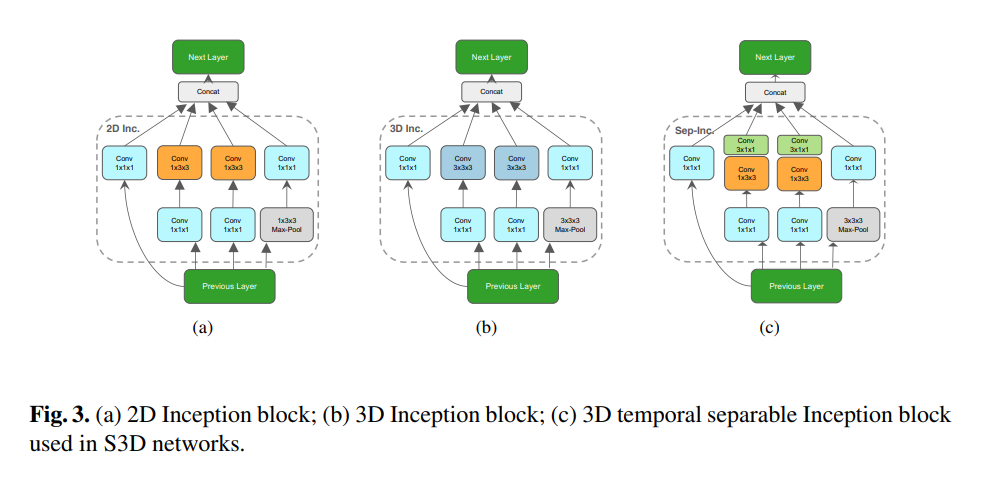

- `Note`: For this network, we will be taking the (c) 3D temporal separable Inception block since our model is an S3D network
- `Important Note`: The Inception block and the model will be modified through the course of training and hyper tuning. Matik panget unang kalalabasan niyan

In [24]:
@keras.saving.register_keras_serializable()
class SepIncBlock(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super(SepIncBlock, self).__init__(**kwargs)

        # Path 1: 1x1x1 Conv (Linear Projection)
        self.conv1x1_1 = layers.Conv3D(filters, kernel_size=(1, 1, 1), strides=1, padding='same', activation='relu')

        # Path 2: 1x1x1 Conv -> 1x3x3 Conv
        self.conv1x1_2 = layers.Conv3D(filters, kernel_size=(1, 1, 1), strides=1, padding='same', activation='relu')
        self.conv1x3x3 = layers.Conv3D(filters, kernel_size=(1, 3, 3), strides=1, padding='same', activation='relu')

        # Path 3: 1x1x1 Conv -> 3x1x1 Conv
        self.conv1x1_3 = layers.Conv3D(filters, kernel_size=(1, 1, 1), strides=1, padding='same', activation='relu')
        self.conv3x1x1 = layers.Conv3D(filters, kernel_size=(3, 1, 1), strides=1, padding='same', activation='relu')

        # Path 4: Pooling -> 1x1x1 Conv
        self.pool = layers.MaxPooling3D(pool_size=(3, 3, 3), strides=1, padding='same')
        self.pool_conv1x1 = layers.Conv3D(filters, kernel_size=(1, 1, 1), strides=1, padding='same', activation='relu')

        # Final Concatenation followed by 1x1x1 Conv
        self.final_conv = layers.Conv3D(filters, kernel_size=(1, 1, 1), strides=1, padding='same', activation='relu')

    def call(self, inputs):
        # Path 1
        p1 = self.conv1x1_1(inputs)

        # Path 2
        p2 = self.conv1x1_2(inputs)
        p2 = self.conv1x3x3(p2)

        # Path 3
        p3 = self.conv1x1_3(inputs)
        p3 = self.conv3x1x1(p3)

        # Path 4
        p4 = self.pool(inputs)
        p4 = self.pool_conv1x1(p4)

        # Concatenate all paths
        concat = layers.Concatenate()([p1, p2, p3, p4])

        # Final 1x1x1 Conv to fuse features
        return self.final_conv(concat)

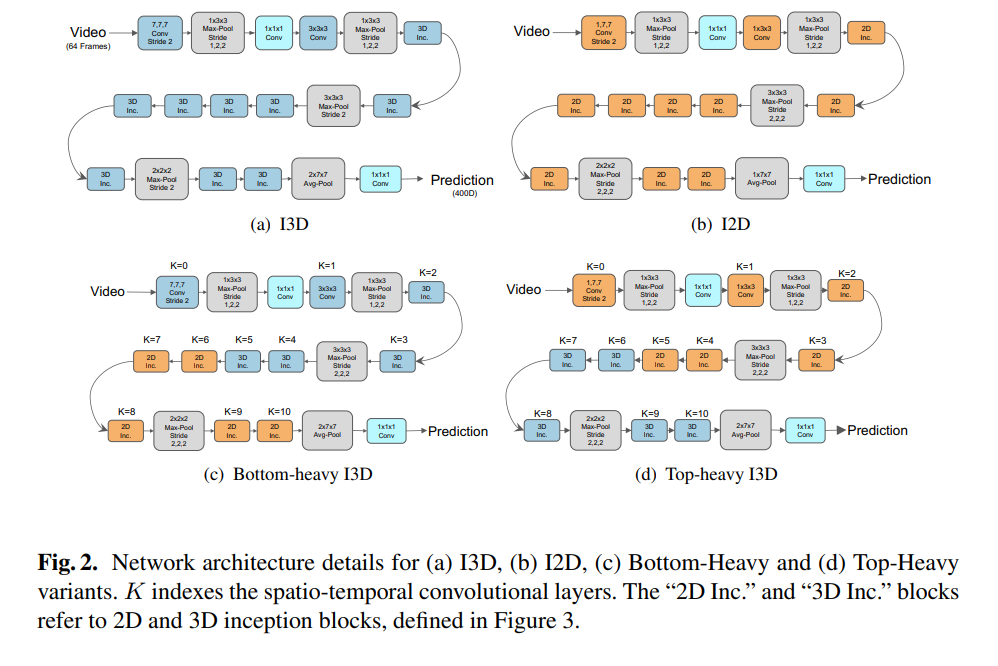

- For this model, we will be using the (a) I3D variant since we already used it on one model design but with some changes

#### Network Building

In [25]:
class S3D(kt.HyperModel):
    def build(self, hp):
        # Define input shape for the video
        input_shape = (None, SEQUENCE_LENGTH, HEIGHT, WIDTH, 3)  
        video_input = layers.Input(shape=input_shape[1:])

        # Initial Conv3D with hyperparameter tuning
        x = layers.Conv3D(
            filters=hp.Int('conv3d_filters1', min_value=32, max_value=128, step=32),
            kernel_size=(7, 7, 7),
            strides=(2, 2, 2),
            padding='same',
            activation='relu'
        )(video_input)
        x = layers.MaxPooling3D(pool_size=(1, 3, 3), strides=(1, 2, 2), padding='same')(x)
        x = layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))(x)

        # Second Conv3D Layer
        x = layers.Conv3D(
            filters=hp.Int('conv3d_filters2', min_value=64, max_value=256, step=64),
            kernel_size=(3, 3, 3),
            strides=(1, 1, 1),
            padding='same',
            activation='relu'
        )(x)
        x = layers.MaxPooling3D(pool_size=(1, 3, 3), strides=(1, 2, 2), padding='same')(x)
        x = layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))(x)

        # First Inception Block
        x = SepIncBlock(filters=hp.Int('sep_inc_filters1', min_value=64, max_value=128, step=32))(x)
        x = layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same')(x)
        x = layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))(x)

        # Second Inception Block
        x = SepIncBlock(filters=hp.Int('sep_inc_filters2', min_value=128, max_value=256, step=64))(x)
        x = layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same')(x)
        x = layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))(x)

        # Third Inception Block
        x = SepIncBlock(filters=hp.Int('sep_inc_filters3', min_value=256, max_value=512, step=128))(x)
        x = layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same')(x)
        x = layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))(x)

        # Fourth Inception Block
        x = SepIncBlock(filters=hp.Int('sep_inc_filters4', min_value=512, max_value=1024, step=128))(x)
        x = layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))(x)

        # Global Average Pooling
        x = layers.GlobalAveragePooling3D()(x)

        # Fully Connected Layers
        x = layers.Dense(
            units=hp.Int('dense_units', min_value=128, max_value=512, step=128),
            activation='relu'
        )(x)
        x = layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))(x)

        # Output layer (classification)
        outputs = layers.Dense(len(LABELS))(x)

        # Compile the model
        model = tf.keras.models.Model(inputs=video_input, outputs=outputs)

        # Optimizer and learning rate selection
        lr = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log')
        optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
        if optimizer_choice == 'adam':
            optimizer = keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0)
        else:
            optimizer = keras.optimizers.RMSprop(learning_rate=lr, rho=0.9, epsilon=1e-7, centered=False)

        # Compile model
        model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

        return model

In [26]:
## Initialize the tuner
tuner = kt.BayesianOptimization(
    hypermodel=S3D(),
    objective='val_accuracy',
    max_trials=5,  # Number of hyperparameter configurations to try
    executions_per_trial=2,  
    directory='S3D',  # Save the tuning results in this directory
    project_name='model_tuning'
)

In [27]:
tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=10  # Number of epochs for each trial
)

Trial 5 Complete [00h 15m 22s]
val_accuracy: 0.35975609719753265

Best val_accuracy So Far: 0.35975609719753265
Total elapsed time: 01h 32m 25s


In [28]:
hyperparams = tuner.get_best_hyperparameters(num_trials=1)[0]
model_3 = tuner.hypermodel.build(hyperparams)

In [29]:
frames, label = next(iter(train_ds))
model_3.build(frames)
model_3.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 20, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_30 (Conv3D)              │ (None, 10, 112, 112,   │        32,960 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_9 (MaxPooling3D)  │ (None, 10, 56, 56, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 10, 56, 56, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_31 (Conv3D)              │ (None, 10, 56, 56, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_10 (MaxPooling3D) │ (None, 10, 28, 28, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 10, 28, 28, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sep_inc_block_4 (SepIncBlock)   │ (None, 10, 28, 28,     │       295,808 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_12 (MaxPooling3D) │ (None, 5, 14, 14, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 5, 14, 14, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sep_inc_block_5 (SepIncBlock)   │ (None, 5, 14, 14, 192) │       689,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_14 (MaxPooling3D) │ (None, 3, 7, 7, 192)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 3, 7, 7, 192)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sep_inc_block_6 (SepIncBlock)   │ (None, 3, 7, 7, 512)   │     4,591,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_16 (MaxPooling3D) │ (None, 2, 4, 4, 512)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 2, 4, 4, 512)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sep_inc_block_7 (SepIncBlock)   │ (None, 2, 4, 4, 512)   │     5,246,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 2, 4, 4, 512)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,043,781 (42.13 MB)

 Trainable params: 11,043,781 (42.13 MB)

 Non-trainable params: 0 (0.00 B)

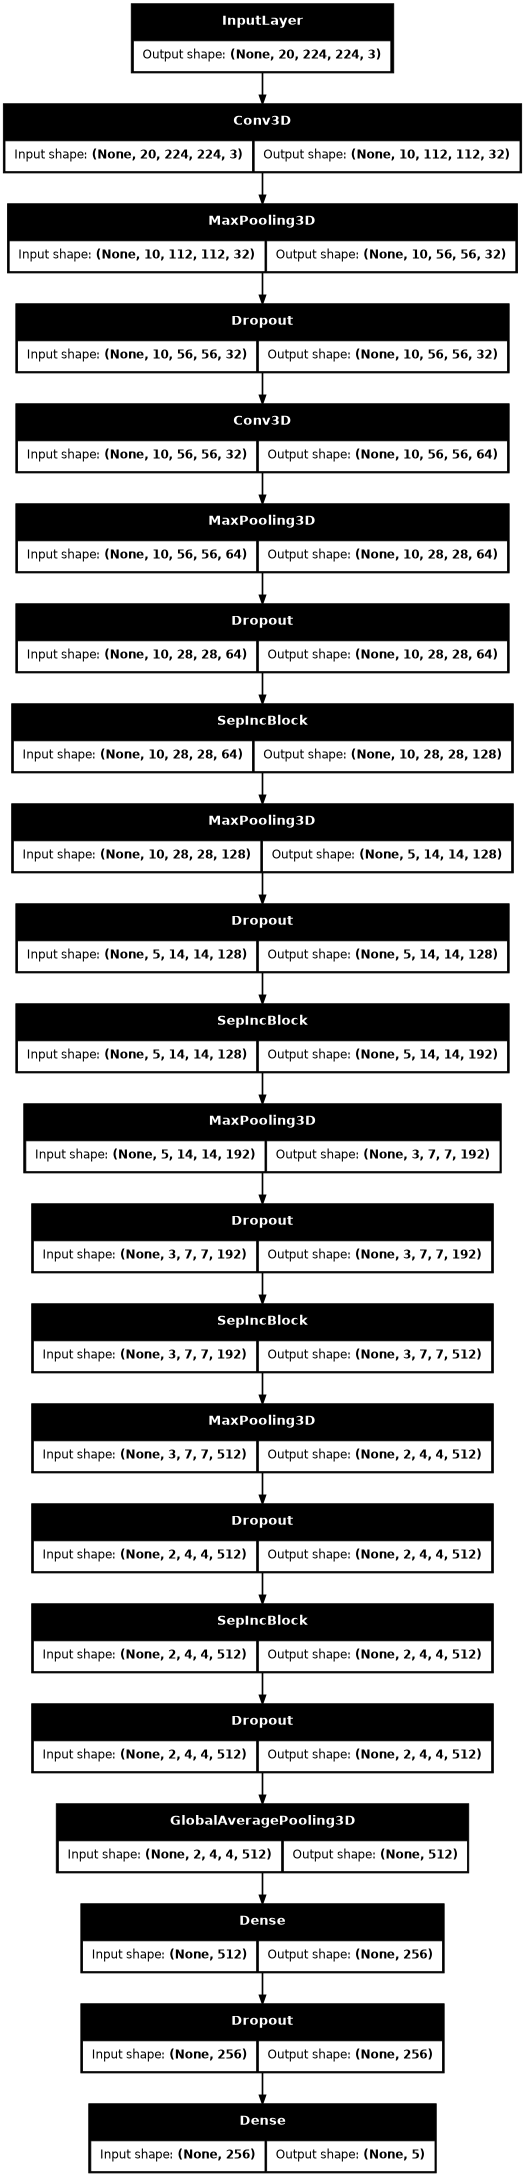

In [30]:
# Visualize the model
keras.utils.plot_model(model_3, expand_nested=True, dpi=60, show_shapes=True)

#### Train the model

In [31]:
# Create a callback that saves the model's weights while training
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_S3D.keras',       
    save_weights_only=False,           
    save_best_only=True,                
    monitor='val_loss',                 
    mode='min',                         
)

early_stopping_model = keras.callbacks.EarlyStopping(
    monitor='val_loss',        
    patience=15,                
    min_delta=1e-4,            
    restore_best_weights=True  
)

In [32]:
history_3 = model_3.fit(x = train_ds,
                    epochs = 300, # You can change this if you want, ikaw bahala
                    callbacks=[checkpoint, early_stopping_model],
                    validation_data = val_ds)

Epoch 1/300
    131/Unknown 48s 342ms/step - accuracy: 0.1991 - loss: 1.6223

/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


131/131 ━━━━━━━━━━━━━━━━━━━━ 72s 521ms/step - accuracy: 0.1992 - loss: 1.6222 - val_accuracy: 0.2073 - val_loss: 1.6085
Epoch 2/300
131/131 ━━━━━━━━━━━━━━━━━━━━ 65s 467ms/step - accuracy: 0.1832 - loss: 1.6105 - val_accuracy: 0.2073 - val_loss: 1.6087
Epoch 3/300
131/131 ━━━━━━━━━━━━━━━━━━━━ 65s 501ms/step - accuracy: 0.2106 - loss: 1.6074 - val_accuracy: 0.2073 - val_loss: 1.6090
Epoch 4/300
131/131 ━━━━━━━━━━━━━━━━━━━━ 71s 545ms/step - accuracy: 0.2056 - loss: 1.6076 - val_accuracy: 0.2317 - val_loss: 1.6067
Epoch 5/300
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 503ms/step - accuracy: 0.1958 - loss: 1.6070 - val_accuracy: 0.2927 - val_loss: 1.6070
Epoch 6/300
131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 511ms/step - accuracy: 0.2258 - loss: 1.6038 - val_accuracy: 0.2073 - val_loss: 1.6094
Epoch 7/300
131/131 ━━━━━━━━━━━━━━━━━━━━ 71s 547ms/step - accuracy: 0.2289 - loss: 1.6044 - val_accuracy: 0.2683 - val_loss: 1.6039
Epoch 8/300
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 507ms/step - accuracy: 0.2253 - loss: 1.601

- `Remarks`: Why use more than 100 epochs you ask? Because some [Indian guy on YouTube](https://youtu.be/QmtSkq3DYko?si=V28jCOfot8MeHep6) used 500 epochs to train his Action Recognition model, therefore it is also wise to use the same training scheme. What a chad!

#### Plot the model and get the metrics

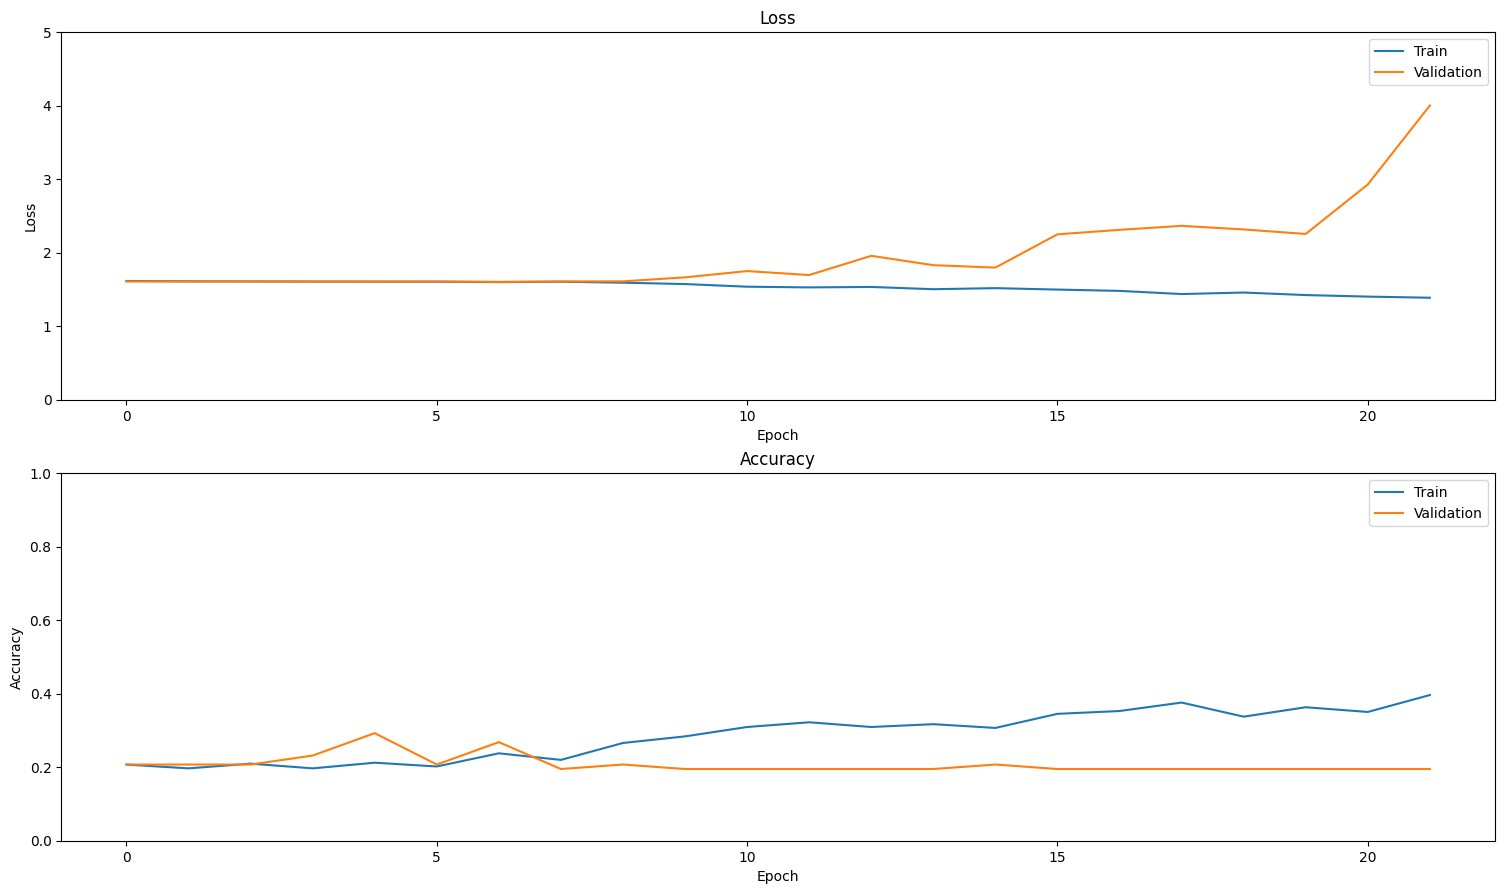

In [33]:
plot_history(history_3)

In [34]:
test_ds = configure_dataset(dataset_paths['test'], SEQUENCE_LENGTH, training=False)

# Create the training set
test_frames, test_labels = next(iter(test_ds))
print(f'Shape of training set of frames: {test_frames.shape}')
print(f'Shape of training labels: {test_labels.shape}')

/mnt/d/vscodeProjects/wincuda/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Shape of training set of frames: (3, 20, 224, 224, 3)
Shape of training labels: (3,)


In [35]:
model_3.evaluate(test_ds, return_dict=True)

30/30 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.0691 - loss: 1.6095


{'accuracy': 0.23863635957241058, 'loss': 1.6057301759719849}

In [36]:
fg = FrameGenerator(dataset_paths['train'], 10, training=True)
labels = list(fg.class_ids_for_name.keys())

131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step


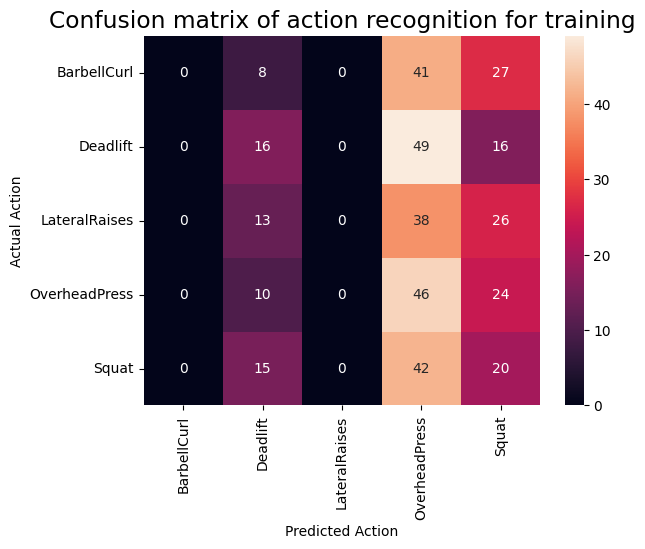

In [37]:
actual, predicted = get_actual_predicted_labels(train_ds, model_3)
plot_confusion_matrix(actual, predicted, labels, 'training')

/mnt/d/vscodeProjects/wincuda/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 27s 899ms/step


/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


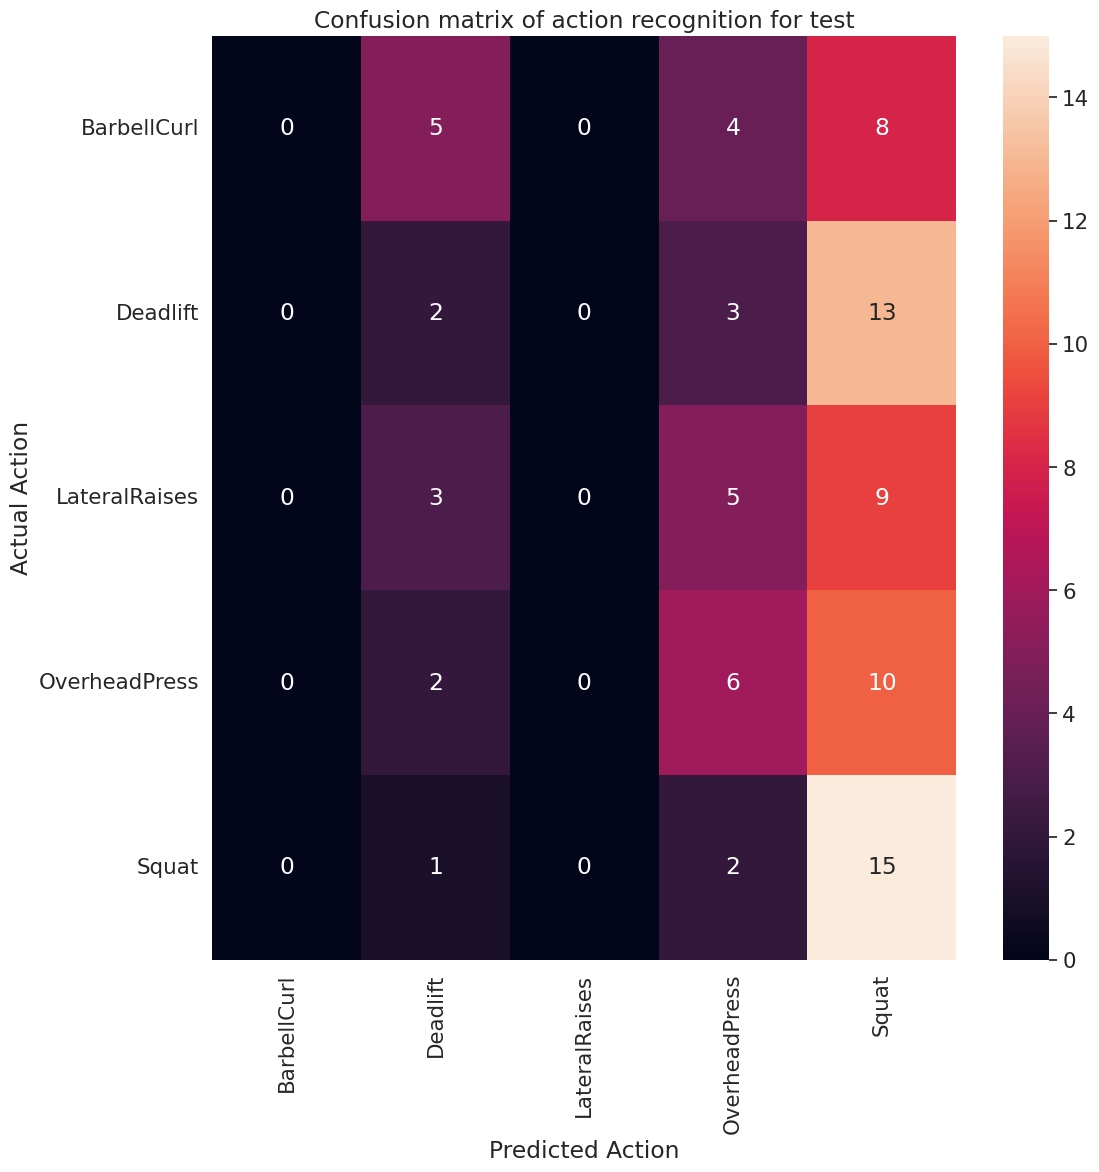

In [38]:
actual, predicted = get_actual_predicted_labels(test_ds, model_3)
plot_confusion_matrix(actual, predicted, labels, 'test')

In [39]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

/tmp/ipykernel_41618/3874706026.py:25: RuntimeWarning: invalid value encountered in scalar divide
  precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision


In [40]:
precision

{'BarbellCurl': nan,
 'Deadlift': 0.15384615384615385,
 'LateralRaises': nan,
 'OverheadPress': 0.3,
 'Squat': 0.2727272727272727}

In [41]:
recall

{'BarbellCurl': 0.0,
 'Deadlift': 0.1111111111111111,
 'LateralRaises': 0.0,
 'OverheadPress': 0.3333333333333333,
 'Squat': 0.8333333333333334}

#### Load Model

In [42]:
## Load model

load_model = keras.models.load_model('model_S3D.keras',
                                    custom_objects={'SepIncBlock': SepIncBlock,
                                                    })

/mnt/d/vscodeProjects/wincuda/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'sep_inc_block_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/mnt/d/vscodeProjects/wincuda/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'sep_inc_block_5', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/mnt/d/vscodeProjects/wincuda/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build(

#### Evaluate model

In [43]:
actual, predicted = get_actual_predicted_labels(test_ds, load_model)

/mnt/d/vscodeProjects/wincuda/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 27s 894ms/step


/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


In [44]:
f1_score = calculate_f1_score(actual, predicted, labels)
f1_score[1]

0.16717442950877848

In [45]:
proba = load_model.predict(test_ds)

30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 777ms/step


In [46]:
MAP = calculate_map(actual, proba, len(labels))
MAP

0.3112822071523823

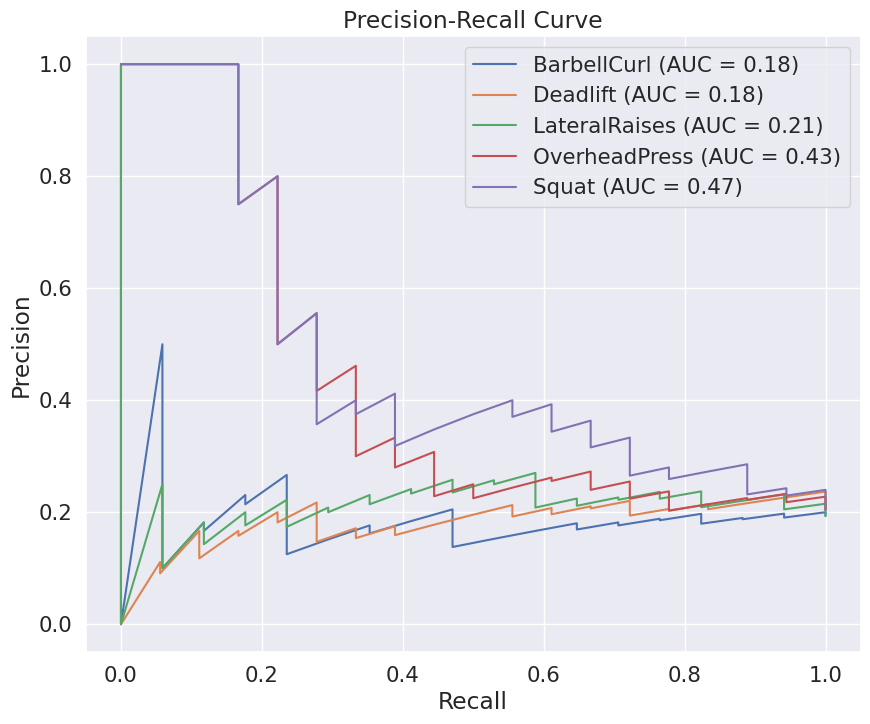

{'BarbellCurl': 0.1823760625411534,
 'Deadlift': 0.1820940058833954,
 'LateralRaises': 0.2099787147998788,
 'OverheadPress': 0.4277959581299058,
 'Squat': 0.4725899704997779}

In [47]:
plot_precision_recall_curve(actual, proba, labels)

In [48]:
import time
import psutil

def measure_latency_cpu_usage(model, test_inputs):
    process = psutil.Process()
    cpu_start = process.cpu_percent()
    start = time.time()
    predictions = model.predict(test_inputs)
    end = time.time()
    cpu_end = process.cpu_percent()
    latency = end - start
    cpu_usage = cpu_end - cpu_start
    return latency, cpu_usage

#### Test Model

In [ ]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

sequence_length = SEQUENCE_LENGTH
resize_shape = (HEIGHT, WIDTH)
file_dir = 'unknown/lunge2.mov'

cap = cv2.VideoCapture(file_dir)
frames = []
predicted_label = ""

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture frame")
        break

    # Process the frame for pose detection
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(rgb_frame)

    # Draw keypoints and connections on the frame
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

    # Resize and prepare frame for prediction
    resized_frame = cv2.resize(frame, resize_shape)
    rgb_resized_frame = resized_frame[:, :, ::-1]
    frames.append(rgb_resized_frame)

    # Add predicted activity label to frame
    display_text = f"Activity: {predicted_label}"
    cv2.putText(frame, display_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    # Display the frame
    cv2.imshow('Cam', frame)

    # Perform prediction every `sequence_length` frames
    if len(frames) == sequence_length:
        frames_array = np.array(frames) / 255.0  # Normalize to [0, 1]
        frames_array = np.expand_dims(frames_array, axis=0)  # Shape (1, sequence_length, height, width, 3)

        prediction = load_model.predict(frames_array)

        # Update predicted label
        predicted_index = np.argmax(prediction, axis=1)[0]
        predicted_label = sorted(LABELS)[predicted_index]
        print("Activity:", predicted_label)

        frames = []

    # Exit loop on 'q' key press
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


/mnt/d/vscodeProjects/wincuda/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Activity: Squat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Activity: Squat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Activity: Squat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Activity: Squat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Activity: Squat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Activity: Squat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Activity: Squat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Activity: Squat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Activity: Squat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Activity: Squat
Failed to capture frame
Latency: 0.06600341796875
